# COGS 108 - Investigation of the U.S. Food and Drug Administration's Recall Events

*Presentation Video: https://youtu.be/qt6LS-d1t04*

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ X ] YES - make available
* [  ] NO - keep private

# Overview

If the food on grocery shelves is deemed unfit for consumption, the U.S. Food and Drug Administration (FDA) provides oversight and ensures products get recollected in a timely matter. Our project aims to find what factors influence how long it takes the FDA to identify the level of danger a recall incident poses to consumers. We initially predicted that more serious recall incidents would take longer for the FDA to classify. We also investigated whether the breadth of product distribution also affects this same measure of time. Through visualizations, combing over rudimentary statistical attributes, and conducting A/B tests, we found no support for our hypothesis, nor did we identify any significant relationship between the scope of product distribution and classification time.

# Names

- Jayden Lee
- Seth Menn
- Mingwen Jiang
- William Nathan
- Antonio Murillo

<a id='research_question'></a>
# Research Question

 Is there a correlation between the severity of a recall incident and the time it takes for the FDA to classify said incident? We define the severity of an incident to be its assigned classification level. And we will measure the time it took to classify the incident as the difference between the date the recall is initiated and the date the incident is listed as classified. Could the scope of the regions involved with product distribution also be related to this timespan measure? Separately, what trends in recall incidents do we see across time?

<a id='background'></a>

## Background & Prior Work

##### Background
  
Food security is a hot topic in the United States. Food manufacturing conglomerates are continually looking for ways to cut costs through automation and hyper optimization, scaling their operations to feed a booming population. With this sheer volume in production comes an increase in the possibility that internal quality control processes cannot validate every single item leaving the production site. If not caught soon enough, the consequences can be fatal if a hazardous product makes it onto a consumer's dinner plate. The FDA (Food and Drug Administration) regulates this space to mitigate these happenings. Among other things, they are tasked with the oversight and tracking of recall incidents by classifying their relative health hazards. Recalls for products that could cause serious injury or death are classified as `Class I`, recalls for products which might cause serious injury or temporary illness are classified as `Class II`, and recalls for products that are unlikely to cause injury or illness but violate some subset of the FDA's regulations are classified as `Class III`. While there are inevitable delays in the vendors or retailers responding to the recall request and being able to fully pull impacted products off of their shelves, what are the factors that affect the time for the enforcement on the FDA's part? What would be the difference in the time between initially receiving the recall incident report and executing the recall under the three classifications? Throughout this project, our team tries to determine the relationship between the recall reaction time and the recall classifications.

##### Prior Work
While there exist several personal notebooks on Kaggle that use this dataset (or variants of it), their general and relatively shallow attempts at exploratory analysis do not address the relationship we are looking to explore. Beyond this, one would assume there are internal reports and audits of the FDA's processes that include food recall and subsequent response times. However, these audits are likely not information the government or third-party regulation agencies would ever feel the need to make public. As such, we can confidentally say our research question has us on a path to complete novel data analysis.

##### References (links included):
- 1) https://www.fda.gov/medical-devices/postmarket-requirements-devices/recalls-corrections-and-removals-devices
- 2) https://www.eatthis.com/news-why-so-many-grocery-recalls-2021/
- 3) https://www.kaggle.com/fda/fda-enforcement-actions/code

# Hypothesis


We hypothesize that it takes longer to classify health-hazardous products (Class I) than less harmful (Class II or Class III) products. We believe that while testing the fineness of all products takes a substantial amount of time, those products with a higher chance of being health-hazardous go through a longer testing process as more regulations need to be checked. Once they acknowledge this inefficiency, the FDA could make modifications to their regulation testing workflow to expedite the testing process of Class I products.

# Dataset(s)

- Dataset Name: `food_enforcement.csv`
- Link to the dataset: [Link](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=fda_food&t=food_enforcement&page=table&project=silken-avatar-335619&ws=!1m15!1m4!4m3!1sbigquery-public-data!2ssdoh_cdc_wonder_natality!3scounty_natality!1m4!4m3!1sbigquery-public-data!2sfda_food!3sfood_enforcement!1m4!4m3!1sbigquery-public-data!2sfda_food!3sfood_events); You might need GCP account to access into `bigquery` cloud
- Number of observations: $21, 525$ recall records

This dataset provides entries given to the FDA by suppliers in response to recall requests. The data includes dates of when the recall request was made and terminated, along with details of what products were included in the recall and where the products where distributed. The variables of interest in this project are recall dates (`recall_initiation_date`), dates of classification (`center_classification_date`), the incident classification level (`classification`), the country in which the responsible recalling firm is located in (`country`), and the states/territories affected product(s) were shipped to (`distribution_pattern`).

# Setup

In [78]:
%matplotlib inline

from iso3166 import countries
from IPython.display import display
from scipy.stats import ttest_ind
import re
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats

# These options will prevent output from ballooning out.
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_seq_items', None)
pd.set_option('expand_frame_repr', True)


In [79]:
# Configure data type of each column for memory optimization.

cols = ['classification', 'center_classification_date', 'report_date',
        'postal_code', 'termination_date', 'recall_initiation_date',
        'recall_number', 'city', 'event_id', 'distribution_pattern',
        'recalling_firm', 'voluntary_mandated', 'state', 'reason_for_recall',
        'initial_firm_notification', 'status', 'product_type', 'country',
        'product_description', 'code_info', 'address_1', 'address_2',
        'product_quantity', 'more_code_info'
        ]

types = [
        str, str, str, str, str, str, str, str, int,
        str, str, str, str, str, str, str, str, str,
        str, str, str, str, str, str
        ]

dtypes = dict(zip(cols, types))


In [80]:
# Load in the dataset from the file.
fp = 'data/food_enforcement.csv'
data = pd.read_csv(fp, dtype=dtypes)

display(data.head())


,classification,center_classification_date,report_date,postal_code,termination_date,recall_initiation_date,recall_number,city,event_id,distribution_pattern,recalling_firm,voluntary_mandated,state,reason_for_recall,initial_firm_notification,status,product_type,country,product_description,code_info,address_1,address_2,product_quantity,more_code_info
0,Class II,2012-08-28,2012-09-05,02720-4713,2012-09-21,2012-08-15,F-2108-2012,Fall River,62868,"Massachusetts, Maryland, New Jersey, New York,...",Blount Seafood Corporation,Voluntary: Firm initiated,MA,Foreign plastic material within the retail units,NaN,Terminated,Food,United States,Wegman's Lobster Bisque 16 oz retail cup Prod...,Lot number 09012-6F Use or Freeze By: 9/3/12,630 Currant Rd,NaN,141 cases/1692 units,NaN
1,Class II,2012-08-28,2012-09-05,02720-4713,2012-09-21,2012-08-15,F-2107-2012,Fall River,62868,"Massachusetts, Maryland, New Jersey, New York,...",Blount Seafood Corporation,Voluntary: Firm initiated,MA,Foreign plastic material within the retail units,NaN,Terminated,Food,United States,Wegman's Caribbean Black Bean Soup 16 oz retai...,Lot number 060512-5F Use or Freeze By: 9/3/12,630 Currant Rd,NaN,143 cases/1716 units,NaN
2,Class II,2012-08-28,2012-09-05,02720-4713,2012-09-21,2012-08-15,F-2106-2012,Fall River,62868,"Massachusetts, Maryland, New Jersey, New York,...",Blount Seafood Corporation,Voluntary: Firm initiated,MA,Foreign plastic material within the retail units,NaN,Terminated,Food,United States,Wegman's Gazpacho Soup 16 oz retail cup Produ...,Lot number 060412-8F Use or freeze By: 9/2/12,630 Currant Rd,NaN,233 cases/2796 units,NaN
3,Class II,2012-08-28,2012-09-05,02720-4713,2012-09-21,2012-08-15,F-2105-2012,Fall River,62868,"Massachusetts, Maryland, New Jersey, New York,...",Blount Seafood Corporation,Voluntary: Firm initiated,MA,Foreign plastic material within the retail units,NaN,Terminated,Food,United States,Wegman's Tomato Basil with Orzo Soup 16 oz ret...,Lot number 060512-3F Use or Freeze By: 9/3/12,630 Currant Rd,NaN,143 cases/1716 units,NaN
4,Class III,2021-07-20,2021-07-28,10001-4006,NaN,2021-07-09,F-0789-2021,New York,88263,"IN, TN, WI, CO, AZ",Bountiful Trading Inc,Voluntary: Firm initiated,NY,Vitamin D dietary supplement may contain Coq10,NaN,Ongoing,Food,United States,"Kroger brand, Vitamin D3 125 mcg softgels, 100...","Prod # 19937, Lot # 508981-02, Exp 02/24 0412...",145 W 30th St Fl 6,NaN,"12,360 bottles",NaN


# Data Cleaning

### Data Type Conversions

Notice there are several attributes in our raw data relevant to date. The two date attributes we plan to use to calculate the amount of time it took for an event to get classified are `center_classification_date` and `recall_initiation_date`. We will first convert the dtypes of these two columns into `datetime` object.

In [81]:
# Define helper function for dtype conversion

def convert_dtype(row):
    '''
    Helper function for load_data
    Sets dtype of time-sensitive attributes to datetime
    If the value is in incomprehensive format for datetime converter function
    function replaces value with null, which will later be dropped
    '''
    date_cols = ['center_classification_date', 'recall_initiation_date']
    date = row[date_cols]

    for col in date_cols:
        val = date[col]
        try:
            converted_date = pd.to_datetime(val)
            row[col] = converted_date
        except(Exception,):
            row[col] = np.NaN

    return row


data = (data.apply(convert_dtype, axis=1)
        .dropna(subset=['center_classification_date',
                        'recall_initiation_date']))

display(data.info(memory_usage=False))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   classification              21524 non-null  object        
 1   center_classification_date  21524 non-null  datetime64[ns]
 2   report_date                 21524 non-null  object        
 3   postal_code                 21333 non-null  object        
 4   termination_date            20421 non-null  object        
 5   recall_initiation_date      21524 non-null  datetime64[ns]
 6   recall_number               21523 non-null  object        
 7   city                        21524 non-null  object        
 8   event_id                    21524 non-null  int64         
 9   distribution_pattern        21524 non-null  object        
 10  recalling_firm              21524 non-null  object        
 11  voluntary_mandated          21520 non-null  object    

None

### Label Generation

For all recall events in our data, each event is associated with a numerically designated class that indicates the relative degree of the health hazard an affected product poses. These are `Class I`, `Class II`, `Class III` respectively. These labels naturally exist as strings, which messes with the ordinal characteristic of our class; `Class I` is the highest health hazard level, and `Class III` is the lowest. We will define a custom data type for this column to correctly represent it as an ordinal categorical attribute.

In [82]:
# Note that 'Class III' is the lowest health hazard level.
vals = [
    'Class I',
    'Class II',
    'Class III'
]

dtype = pd.CategoricalDtype(vals[::-1], ordered=True)

# New dtype assignment
data['classification'] = data['classification'].astype(dtype)

display(data.info(memory_usage=False))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   classification              21524 non-null  category      
 1   center_classification_date  21524 non-null  datetime64[ns]
 2   report_date                 21524 non-null  object        
 3   postal_code                 21333 non-null  object        
 4   termination_date            20421 non-null  object        
 5   recall_initiation_date      21524 non-null  datetime64[ns]
 6   recall_number               21523 non-null  object        
 7   city                        21524 non-null  object        
 8   event_id                    21524 non-null  int64         
 9   distribution_pattern        21524 non-null  object        
 10  recalling_firm              21524 non-null  object        
 11  voluntary_mandated          21520 non-null  object    

None

### Handling Duplicates

Our dataset contains over 21,000 total records of incident data. But does that mean it contains that many total incidents? It appears that multiple records can be tied to a singular incident identification number (`event_id`). The only separable features to discern incidents under this same number is their various production information that are ultimately irrelevant to our analysis. Therefore it would be a good idea to keep only one record per `event_id`.

In [83]:
print(data.shape)


(21524, 24)


In [84]:
data = data.drop_duplicates('event_id')


In [85]:
print(data.shape)


(5530, 24)


We see that we reduced the size of our dataset by nearly 75%.

### Decreasing Dimensionality 

Our dataset contains 24 different attributes. While some of them will be of use to us, others are completely irrelevant to our project or have values that would otherwise make them unsuitable for analysis going forward. For example, a majority of values in the `address_2` and `more_code_info` columns are filled with a multitude of null values. Since those will not be helpful for the scope of our project and can cause distortions in future analysis, we will exclude those preemptively.

In [86]:
# Define column labels we don't need

excludes = [
    'postal_code', 'report_date', 'termination_date',
    'recall_number', 'event_id', 'voluntary_mandated',
    'initial_firm_notification', 'code_info', 'more_code_info',
    'address_1', 'address_2', 'product_quantity',
    'status', 'product_type', 'product_description',
    'recalling_firm', 'reason_for_recall',
    ]

# Drop those columns
data = data.drop(columns=excludes)

display(data.head())


,classification,center_classification_date,recall_initiation_date,city,distribution_pattern,state,country
0,Class II,2012-08-28,2012-08-15,Fall River,"Massachusetts, Maryland, New Jersey, New York,...",MA,United States
4,Class III,2021-07-20,2021-07-09,New York,"IN, TN, WI, CO, AZ",NY,United States
5,Class I,2021-09-21,2021-08-30,Astoria,"New York, Maryland, Virginia, Pennsylvania, Co...",NY,United States
6,Class II,2019-05-13,2019-04-15,Brooklyn,Distributed to 16 retailers in the Brooklyn & ...,NY,United States
7,Class I,2013-11-01,2013-09-25,Pittsburgh,"MD, OH, PA, WV",PA,United States


### Calculating Classification Duration

We add a new column to the dataset given how long it took to classify each recall incident measured in total days.

In [87]:
data.insert(6,'classification_duration', 0 ,False)
data['classification_duration'] = (data['center_classification_date']
                                   - data['recall_initiation_date']).dt.days


In [88]:
display(data.head())


,classification,center_classification_date,recall_initiation_date,city,distribution_pattern,state,classification_duration,country
0,Class II,2012-08-28,2012-08-15,Fall River,"Massachusetts, Maryland, New Jersey, New York,...",MA,13,United States
4,Class III,2021-07-20,2021-07-09,New York,"IN, TN, WI, CO, AZ",NY,11,United States
5,Class I,2021-09-21,2021-08-30,Astoria,"New York, Maryland, Virginia, Pennsylvania, Co...",NY,22,United States
6,Class II,2019-05-13,2019-04-15,Brooklyn,Distributed to 16 retailers in the Brooklyn & ...,NY,28,United States
7,Class I,2013-11-01,2013-09-25,Pittsburgh,"MD, OH, PA, WV",PA,37,United States


We also need to get a rough idea of what countries (other than the United States) recalling firms are based in.

In [89]:
display(data[data['country'] != 'United States'])


,classification,center_classification_date,recall_initiation_date,city,distribution_pattern,state,classification_duration,country
712,Class I,2021-11-17,2021-10-28,Leamington,Domestic distribution - Florida,NaN,20,Canada
713,Class II,2021-01-27,2021-01-14,Seoul,"NJ, WA, CA, MD, NY",NaN,13,Korea (the Republic of)
714,Class I,2019-01-28,2018-12-07,Guadalajara,United States,NaN,52,Mexico
715,Class II,2019-02-05,2018-12-05,Bristol,US Distribution: Direct to CA and MA,NaN,62,United Kingdom
716,Class II,2021-09-13,2021-05-25,Maple Ridge,"Distributed in Arizona, California, Florida, K...",NaN,111,Canada
...,...,...,...,...,...,...,...,...
13421,Class II,2018-11-30,2018-10-30,Delta,Missouri,NaN,31,Canada
13422,Class II,2013-10-30,2013-10-07,Mississauga,Canada,Ontario,23,Canada
13426,Class I,2019-08-21,2019-07-12,Saint-Leonard,GOODS WERE DISTRIBUTED ACROSS THE STATES OF NE...,NaN,40,Canada
13428,Class II,2017-08-04,2017-06-22,Toronto,Puerto Rico only,NaN,43,Canada


### Column Standardization

Because a number of the columns are inputted by the individual firms without a specific format, they are relatively inconsistent across the board. In this section we will standardize the columns we will most certainly need during our analysis.

We should go ahead and get rid of the remaining missing values not already taken care of before going any further.

In [90]:
print(data.shape)


(5530, 8)


In [91]:
data = data.dropna()


In [92]:
print(data.shape)


(5446, 8)


Moving forward, now we need to get an idea of what different types of region inputs we have for the distribution pattern.

In [93]:
distribution_counts = pd.DataFrame(data.value_counts(subset=['distribution_pattern'])).reset_index()
distribution_counts.rename(columns={0:'count'}, inplace=True)

display(distribution_counts)


,distribution_pattern,count
0,Nationwide,166
1,CA,51
2,NY,50
3,Texas,45
4,nationwide,35
...,...,...
4385,"FL, GA KY, NC, OH, PA, SC, TN and WV.",1
4386,"FL, GA and TX.",1
4387,"FL, GA, IA, IL, NC, RI, TN, TX, VA, & WA.",1
4388,"FL, GA, IL, IN, KS, KY, MA, MI, MO, MC, OH, PA...",1


The state column has U.S states in abbreviations while other territories are displayed as their full names. We will translate the U.S state abbreviations into their corresponding full names as well for consistency.

In [94]:
# Define a state to abbreviation mapping for conversion.
code_to_state = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
    'DC': 'District of Columbia',
    'AS': 'American Samoa',
    'GU': 'Guam',
    'MP': 'Northern Mariana Islands',
    'PR': 'Puerto Rico',
    'UM': 'United States Minor Outlying Islands',
    'VI': 'U.S. Virgin Islands'
    }

data['state'] = data['state'].replace(code_to_state)


The `distribution_pattern` column, again, was inputted by hand and its inputs vary far too wildly. We will need to create a new column called `distribution_scope` which is a simplified version of `distribution_pattern`. Their values will be either be *International*, *Nationwide*, or *NaN* (when the scope cannot be determined from the associated pattern). We will look for certain keywords like country names for *International* or state names and/or abbreviations for *Nationwide*.

First we setup the list of countries and states and generate corresponding regex patterns for them.

In [95]:
# setup to standardize distribution
other_countries = list(map(lambda x: x.name, countries))
other_countries.remove('United States of America')
other_countries.remove('United States Minor Outlying Islands')
other_countries.remove('Virgin Islands, U.S.')

country_regex = '|'.join(map(re.escape, map(lambda x: x.lower(),
                                            other_countries)))
code_regex = '|'.join(map(re.escape, code_to_state.keys()))
state_regex = '|'.join(map(re.escape, map(lambda x: x.lower(),
                                          code_to_state.values())))


Then we assign values to scope based on the keywords found in respective patterns.

In [96]:
# Let's go ahead and standardize the distribution pattern.

data['distribution_scope'] = np.nan

dist = data['distribution_pattern']

data.loc[dist.str.lower().str.contains('nationwide'),
         'distribution_scope'] = 'Nationwide'
data.loc[dist.str.lower().str.contains('united states'),
         'distribution_scope'] = 'Nationwide'
data.loc[dist.str.lower().str.contains('domestic'),
         'distribution_scope'] = 'Nationwide'
data.loc[dist.str.contains(code_regex),
         'distribution_scope'] = 'Nationwide'
data.loc[dist.str.contains('US'),
         'distribution_scope'] = 'Nationwide'
data.loc[dist.str.contains('U.S.'),
         'distribution_scope'] = 'Nationwide'
data.loc[dist.str.lower().str.contains(state_regex),
         'distribution_scope'] = 'Nationwide'
data.loc[dist == 'Distributed to all 50 states.  No foreign countries.',
         'distribution_scope'] = 'Nationwide'

data.loc[dist.str.lower().str.contains('international'),
         'distribution_scope'] = 'International'
data.loc[dist.str.lower().str.contains('worldwide'),
         'distribution_scope'] = 'International'
data.loc[dist.str.lower().str.contains(country_regex),
         'distribution_scope'] = 'International'


In [97]:
display(data.head())


,classification,center_classification_date,recall_initiation_date,city,distribution_pattern,state,classification_duration,country,distribution_scope
0,Class II,2012-08-28,2012-08-15,Fall River,"Massachusetts, Maryland, New Jersey, New York,...",Massachusetts,13,United States,International
4,Class III,2021-07-20,2021-07-09,New York,"IN, TN, WI, CO, AZ",New York,11,United States,Nationwide
5,Class I,2021-09-21,2021-08-30,Astoria,"New York, Maryland, Virginia, Pennsylvania, Co...",New York,22,United States,Nationwide
6,Class II,2019-05-13,2019-04-15,Brooklyn,Distributed to 16 retailers in the Brooklyn & ...,New York,28,United States,Nationwide
7,Class I,2013-11-01,2013-09-25,Pittsburgh,"MD, OH, PA, WV",Pennsylvania,37,United States,Nationwide


Throughout this section, we removed all missing values, duplicate records, and columns not relevant to our project. Separately, we either formatted existing columns or created new columns that we'll need going forward. Our dataset is now in a state that is much more suitable for analysis.

# Data Analysis & Results

### Recall and Classification Events Through the Years

We need to get a rough estimate of what trends exist across the timespan covered by our dataset. Let's go ahead and look at the total number of recall and classification events plotted against time.

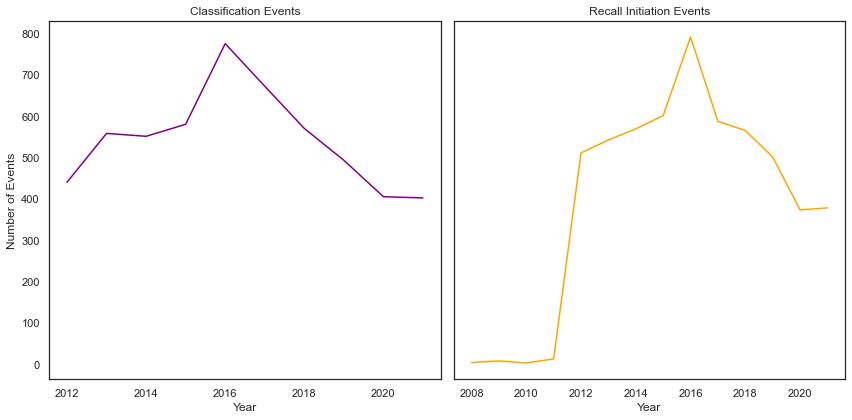

In [116]:
# Add a columm dedicated to years to look at breakdown on a per year basis.
data['year_classification'] = pd.DatetimeIndex(
    data['center_classification_date']).year
data['year_recall_initiation'] = pd.DatetimeIndex(
    data['recall_initiation_date']).year

# Turn the value counts series into something useable with columns names.
# classification events
raw_year_classification_count = pd.DataFrame(
    data.value_counts(subset='year_classification')).reset_index()
raw_year_classification_count.rename(
    columns={0: 'num of classification events'},
    inplace=True
    )

# recall events
raw_year_recall_iniation_count = pd.DataFrame(
    data.value_counts(subset='year_recall_initiation')).reset_index()
raw_year_recall_iniation_count.rename(
    columns={0: 'num of recall initiation events'},
    inplace=True
    )

# Start plotting and tweaking configs.
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.lineplot(x='year_classification',
             y='num of classification events',
             data=raw_year_classification_count,
             ax=ax1,
             color='purple'
             )
sns.lineplot(x='year_recall_initiation',
             y='num of recall initiation events',
             data=raw_year_recall_iniation_count,
             ax=ax2,
             color='orange'
             )

ax1.set_title('Classification Events')
ax2.set_title('Recall Initiation Events')

ax1.set_xlabel('Year')
ax2.set_xlabel('Year')

ax1.set_ylabel('Number of Events')
ax2.set_ylabel('Number of Events')

plt.rcParams['figure.figsize'] = (12, 6)
plt.tight_layout()
plt.show()


Looking at these plots side by side, it's worth pointing out the recall initiations would come before an actual classification event; a recall event needs to be identified before it can be classified. We see that recall initiation events span further back than the first recorded classification event. 2012 is likely the first year in which the FDA made this information public, and classification events that occurred during 2010 or maybe even 2011 subsequently had recalls that were initiated in years prior. If classification events from years before 2012 were included, then some of them would also have recall initiation events that span back further back into previous years. Continuing, we see a peak in total events during 2016, but then a downward trend and then a complete flatline into 2020.

Let's get a better understanding of what's going on within our three classification levels during this same period of time.

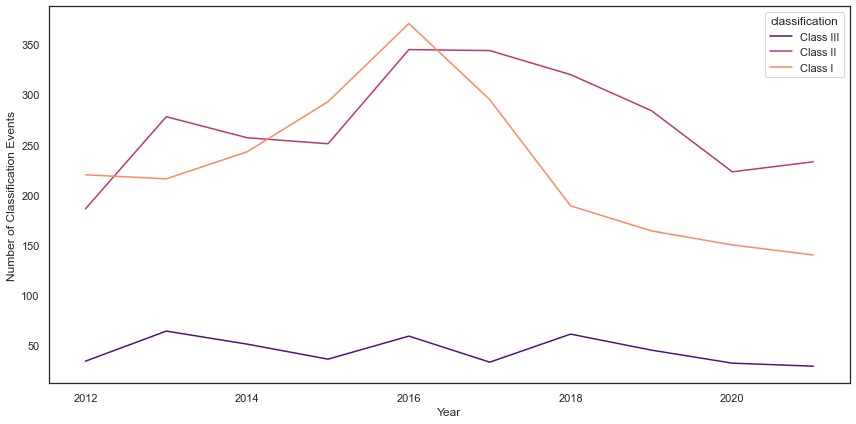

In [99]:
year_classification_count = pd.DataFrame(data.value_counts(
    subset=['year_classification', 'classification']))

# Turn the value counts series into something useable with columns names.
year_classification_count.reset_index(inplace=True)
year_classification_count.rename(columns={0: 'num of classification events'},
                                 inplace=True)

# Start plotting and tweaking configs.
ax = sns.lineplot(x='year_classification',
                  y='num of classification events',
                  hue='classification',
                  data=year_classification_count,
                  palette='magma')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Classification Events')

plt.rcParams['figure.figsize'] = (12, 6)
plt.tight_layout()
plt.show()


So while we still see a dropoff in total events, this plot gives us considerably more insight into underlying trends. First and foremost, `Class III` events (the least severe of the three) see a trend that mostly ebbs and flows, just barely tailing off through 2020.

Right around 2014 we see `Class I` overtake `Class II` as the most common classification event and peaks during 2016, which is the peak year of all total classification events. Given that this is the most severe classification level, we would not expect it to be the most common nor would we want it to given its implications of serious health risks for consumers. One could imagine there might be a push on the part of the FDA to put pressure on food factories to reverse this trend (i.e. via the threat of more severe punishment). It follows that in the two years between 2016 and 2018, rates of `Class I` dropped at significantly greater rates in comparison to the increase seen over the four previous years between 2012 and 2016.

`Class II` swiftly overtakes `Class I` as the most common classification level well under only a year after 2016. It sees a much more gradual decline leading into 2020, but interestingly and without explanation sees an uptick through that year where the other two trend downward.

2020 was quite the anomaly with total incident and classification events being significantly lower in comparison to years past. Let's look at our plots on a per month basis specifically during 2020 to try and get a better idea of what went on.

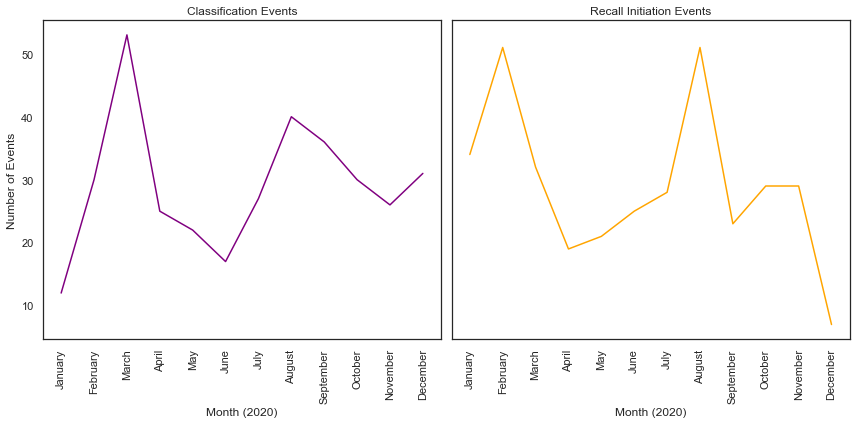

In [100]:
# Grab the subset of data belonging to 2020.
data_for_2020 = (data[(data['year_classification'] == 2020)
                      & (data['year_recall_initiation'] == 2020)]
                 .copy(deep=True))

# Our breakdown should be on a per month basis, so let's add a new
# 'month' columns to this subset.
data_for_2020.loc[:, 'month_classification'] = (pd.DatetimeIndex(
    data_for_2020['center_classification_date'])).strftime('%B')
data_for_2020.loc[:, 'month_recall_initiation'] = (pd.DatetimeIndex(
    data_for_2020['recall_initiation_date'])).strftime('%B')

# Turn the value counts series into something useable with columns names.
# classification events
raw_month_classification_count = pd.DataFrame(
    data_for_2020.value_counts(subset='month_classification')).reset_index()
raw_month_classification_count = raw_month_classification_count.rename(
    columns={0: 'num of classification events'})

# recall events
raw_month_recall_iniation_count = pd.DataFrame(
    data_for_2020.value_counts(subset='month_recall_initiation')).reset_index()
raw_month_recall_iniation_count = raw_month_recall_iniation_count.rename(
    columns={0: 'num of recall initiation events'})

# We need to force the sort order based on the months of the year.
# By default, this will not happen and our plot will be out of order.
MONTHS_OF_THE_YEAR = ['January', 'February', 'March',
                      'April', 'May', 'June',
                      'July', 'August', 'September',
                      'October', 'November', 'December'
                      ]

# classification events
raw_month_classification_count['month_classification'] = pd.Categorical(
    raw_month_classification_count['month_classification'],
    categories=MONTHS_OF_THE_YEAR,
    ordered=True)
raw_month_classification_count['month_classification'] \
    = raw_month_classification_count['month_classification'].sort_values()

# recall events
raw_month_recall_iniation_count['month_recall_initiation'] \
    = pd.Categorical(
        raw_month_recall_iniation_count['month_recall_initiation'],
        categories=MONTHS_OF_THE_YEAR,
        ordered=True)
raw_month_recall_iniation_count['month_recall_initiation'] = \
    (raw_month_recall_iniation_count['month_recall_initiation'].sort_values())

# Start plotting and tweaking configs.
fig2, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.lineplot(x='month_classification',
             y='num of classification events',
             data=raw_month_classification_count,
             ax=ax1,
             color='purple')
sns.lineplot(x='month_recall_initiation',
             y='num of recall initiation events',
             data=raw_month_recall_iniation_count,
             ax=ax2,
             color='orange'
             )

ax1.set_title('Classification Events')
ax2.set_title('Recall Initiation Events')

ax1.set_xlabel('Month (2020)')
ax2.set_xlabel('Month (2020)')

ax1.set_ylabel('Number of Events')
ax2.set_ylabel('Number of Events')

ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

plt.rcParams['figure.figsize'] = (12, 6)
plt.tight_layout()
plt.show()


Taking into account the time in between a recall initiation event and a classification event, we can effectively ignore both head and tail end differences between the two plots, as these pairs would be split at the end and beginning of the years (i.e. a recall initiation occurring in the final week of December would likely not see an associated classification event until January of the next year.) Both plots follow very similar trends.

With that being said, the plot on the right shows a stretch of five months between March and July where the number of new recall events is relatively low. As we move closer towards and into July, we see incident rates steadily increasing. The spike that comes in August, however, is incredibly interesting! What could be the cause for such a dramatic change? Might these shifts in rates across specific months align with the COVID-19 lockdown during this year? Might we take head of this when drawing up final conclusions about relationships?

### Breakdown of Classification Types

Let's also look at the breakdown of classification type for all incidents.

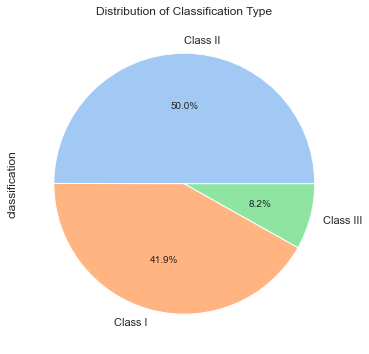

In [101]:
type_count = data['classification'].value_counts()
chart = type_count.plot(kind='pie', autopct='%1.1f%%')
chart.set_title('Distribution of Classification Type')

plt.show()


Looking at this chart, we see that we have far fewer Class III incidents in comparison to both Class I and Class II incidents. Given this smaller sample size, this group is subject to inherently more variance. We will keep note of this fact should we calculate means.

### Classification Duration Distributions Through Time

To further examine the pattern of time needed by the FDA to classify the relative hazard level a recall incident poses, this section will present histograms that give greater insight into distribution trends across different lengths of time. 

In [102]:
DAYS_IN_YEAR = 365

# Generate new dataframes which are seperated by year.
less_than_year = data[data['classification_duration'] <= DAYS_IN_YEAR]
greater_than_year = data[data['classification_duration'] > DAYS_IN_YEAR]
less_than_six_months = \
    data[data['classification_duration'] <= DAYS_IN_YEAR / 2]


We have generated three new DataFrames above. Each DataFrame respectively either holds a data slice of records with a classification duration that spans less than one year, more than one year, or less than half of a year.

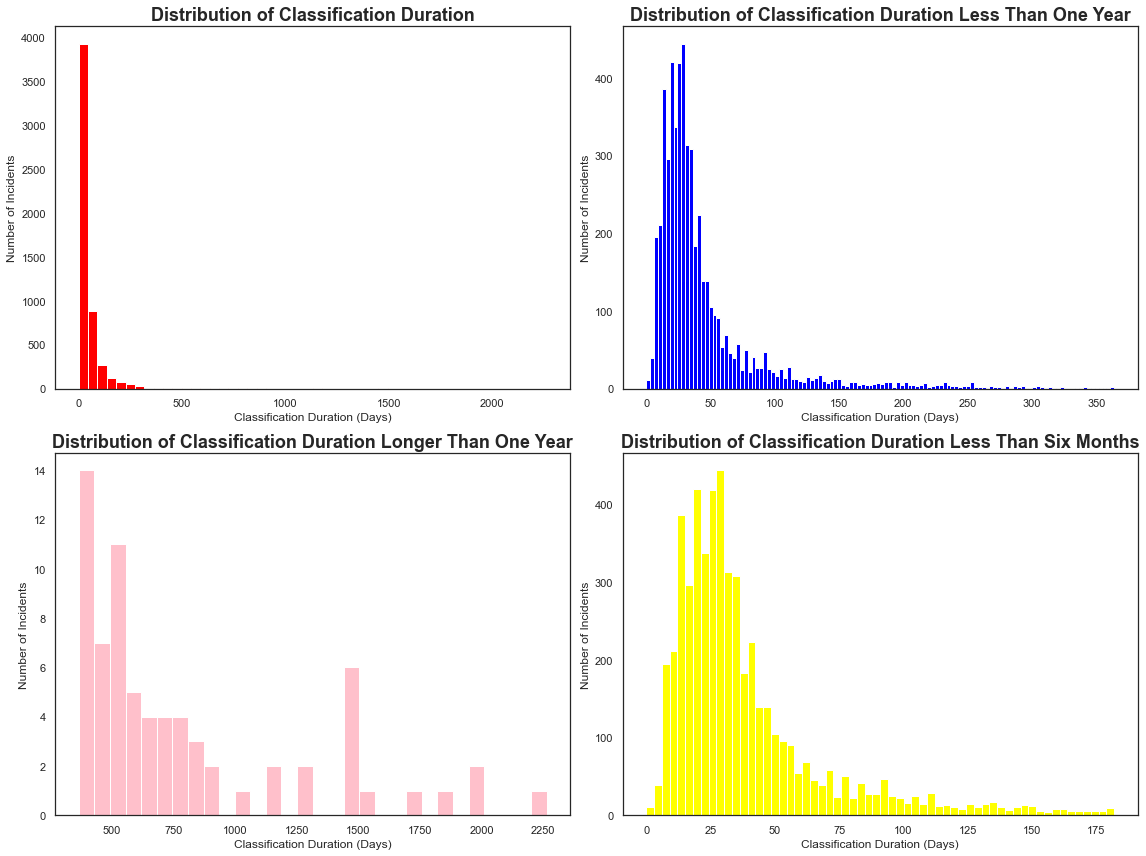

In [103]:
# Setup four subplots.
freq = plt.figure(figsize=(16, 12))
ax1 = freq.add_subplot(221)
ax2 = freq.add_subplot(222)
ax3 = freq.add_subplot(223)
ax4 = freq.add_subplot(224)

# Plot 1 is of all durations.
ax1.hist(x='classification_duration',
         data=data,
         color='red',
         bins=50
         )
ax1.set_xlabel('Classification Duration (Days)')
ax1.set_ylabel('Number of Incidents')
ax1.set_title('Distribution of Classification Duration',
              weight='bold',
              fontsize=18
              )

# Plot 2 is of durations <= 1 year.
ax2.hist(x='classification_duration',
         data=less_than_year,
         color='blue',
         bins=120
         )
ax2.set_xlabel('Classification Duration (Days)')
ax2.set_ylabel('Number of Incidents')
ax2.set_title('Distribution of Classification Duration Less Than One Year',
              weight='bold',
              fontsize=18
              )

# Plot 3 is of durations > 1 year.
ax3.hist(x='classification_duration',
         data=greater_than_year,
         color='pink',
         bins=30
         )
ax3.set_xlabel('Classification Duration (Days)')
ax3.set_ylabel('Number of Incidents')
ax3.set_title('Distribution of Classification Duration Longer Than One Year',
              weight='bold',
              fontsize=18
              )

# Plot 4 is of durations <= 6 months.
ax4.hist(x='classification_duration',
         data=less_than_six_months,
         color='yellow',
         bins=60
         )
ax4.set_xlabel('Classification Duration (Days)')
ax4.set_ylabel('Number of Incidents')
ax4.set_title('Distribution of Classification Duration Less Than Six Months',
              weight='bold',
              fontsize=18
              )

plt.tight_layout()
plt.show()


The first histogram shows that the distribution of the `classification_duration` column is right-skewed, with most of the datapoints concentrating on the bin of fewer than 250 days. The second histogram effectively zooms in by only including incidents that took less than one year to be classified. Here we can still see a right-skewness. Continuing, we can key in on the tail of distribution by only incidents with classfication durations that span longer than one year. Moving forward, the fourth histogram includes only incidents that took less than six months to classify. This plot shows a similar distribution to the that includes durations less than one year.

The biggest takeaway is that most of the incidents have classification durations in the range 0 to 50 total days, with a peak at around 25 days. In summary, a significant amount of incidents get classified in roughly a month, but of course, there are still plenty that take much longer than this.

### Distribution Scope vs. Classification Duration

We suspect that one of the contributing factors to how long the FDA takes to assign a classification level is the scope of the original product distribution. Intuitively, it takes a much greater effort to track down and validate products that ended up on the other side of the globe versus ones that never left the country. This section investigates whether distribution scope significantly affects classification duration.

We will first compare the classification duration of regional distributions that span internationally against ones that domestically span nationwide.

In [104]:
display(data[data['distribution_scope']
             == 'International']['classification_duration'].describe()
        )


count     932.000000
mean       59.288627
std       114.086816
min         4.000000
25%        21.000000
50%        32.000000
75%        53.000000
max      1487.000000
Name: classification_duration, dtype: float64

In [105]:
display(data[data['distribution_scope']
             == 'Nationwide']['classification_duration'].describe()
        )


count    4410.000000
mean       53.107029
std       103.978069
min         0.000000
25%        20.000000
50%        30.000000
75%        48.000000
max      2264.000000
Name: classification_duration, dtype: float64

At first glance, these general statistics show that both could belong in the same group. Visualizing them using histograms may help tell us if this is the case.

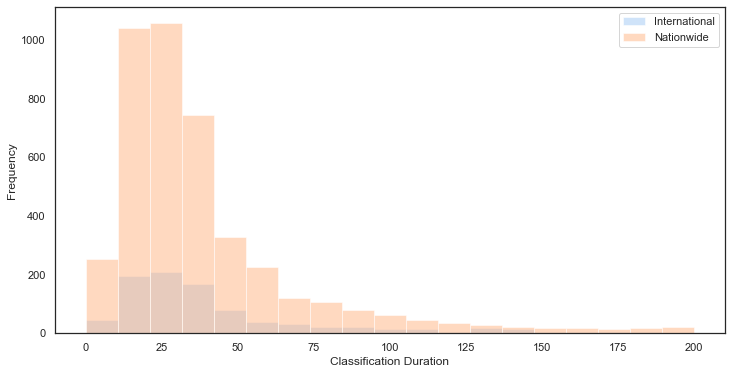

In [106]:
international_duration = data[data['distribution_scope'] 
                              == 'International']['classification_duration']
nationwide_duration = data[data['distribution_scope']
                           == 'Nationwide']['classification_duration']
bins = np.linspace(0, 200, 20)

plt.hist(international_duration, alpha=0.5, label='International', bins=bins)
plt.hist(nationwide_duration, alpha=0.5, label='Nationwide', bins=bins)
plt.legend(loc='upper right')
plt.xlabel('Classification Duration')
plt.ylabel('Frequency')
plt.show()


At first glance, the shapes look similar. But because there is a significant difference between sample sizes, we cannot determine whether the distributions are the same from the histogram alone. To properly verify this, we need to conduct an independent samples t-test. We first need to ensure our data meets basic assumptions before using any parametric statistical test.

The sample size for incidents that span only nationwide is 4,410 while the sample size for incidents that stretch internationally is 932. We feel these numbers show we have enough data to ensure a smooth distribution curve. Let us continue.

Let us first define a function to more easily plot mean distributions via random sampling. We will use this to verify whether or not the distributions are normal.

In [107]:
def plot_means(distribution, n, color):
    """Plot a meaning distribution with a histogram using randomly sampling.

    Keyword arguments:
    distribution -- the distribution to plot
    n -- number of attempts
    color -- color of this plot
    """
    averages = []
    for i in np.arange(n):
        random_sample = distribution.sample(1000, replace=True)
        new_average = np.mean(random_sample)
        averages.append(new_average)

    averages = np.array(averages)

    plt.hist(averages, alpha=1.0, label='Averages', bins=30, color=color)
    plt.xlabel('Classification Duration Means')
    plt.ylabel('Frequency')
    plt.show()


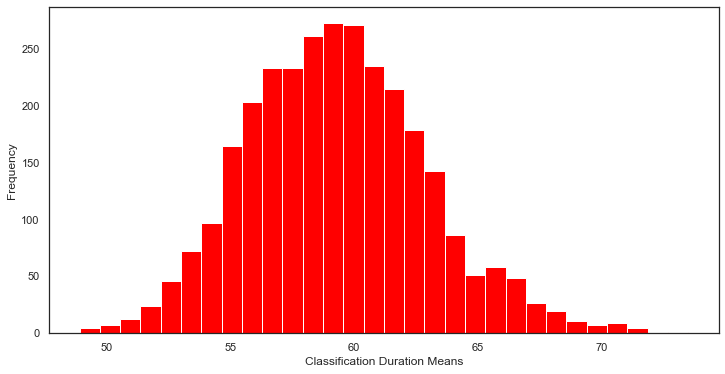

In [108]:
plot_means(international_duration, 3000, 'red')


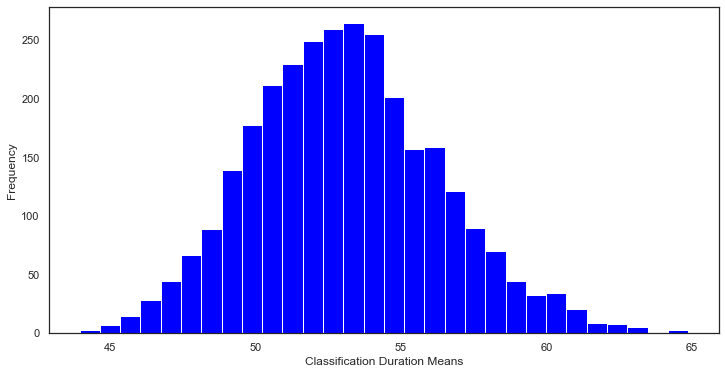

In [109]:
plot_means(nationwide_duration, 3000, 'blue')


Because the distributions of the mean of both appear to be normal, we can proceed with the t-test.

In [110]:
t_val, p_val = ttest_ind(a=international_duration, b=nationwide_duration)

print('t-value: ', t_val, '\np-value: ', p_val)


t-value:  1.6205008604011195 
p-value:  0.10518377362194532


We see a p-value here that is approximately 0.1, which is not very significant. Thus, we fail to reject the null hypothesis, and the distribution scope does not affect the classification duration.

### Classification Duration vs. Classification Level

Per our research question, we hypothesized that it takes longer to classify health-hazardous incidents (`Class I` recall events) than to classify less harmful  (`Class II` and `Class III` recall events). We will examine this by investigating multiple parameters of `classification_duration` and `classification`.

We will first compute the mean and variance of `classification_duration` along with the total count of recall events in our dataset.

In [111]:
# Generate basic summary statistics for classification_duration.
stat_duration_per_class = data.groupby('classification') \
    .aggregate(temp1=('classification_duration', 'mean'),
               temp2=('classification_duration', 'var'),
               temp3=('classification_duration', 'count')
               )

# We'll use this mapping to rename our columns.
COLUMN_MAP = dict(zip(['temp1', 'temp2', 'temp3'],
                      ['Average Duration', 'Variance', 'Count']
                      )
                  )
stat_duration_per_class = stat_duration_per_class.rename(columns=COLUMN_MAP)

# Round off our values to the nearest thousandth.
stat_duration_per_class = stat_duration_per_class \
    .transform(lambda x: round(x, 2))

display(stat_duration_per_class.T)


classification,Class III,Class II,Class I
Average Duration,58.52,51.06,58.73
Variance,8396.05,10703.36,14979.66
Count,444.00,2721.00,2281.00


Before we make a judgement on these summary statistics, let's visualize things by sticking `classification` and `Average duration` on a horizontal bar plot for easier readability.

In [112]:
df = stat_duration_per_class.reset_index()

# Map the classification groups to individual colors for plotting purposes.
df['color'] = ['red', 'blue', 'green']

selection = alt.selection_single()
chart = alt.Chart(df,
                  width=600,
                  height=300,
                  title='Average Number of Days Classfication Took'
                  )

# Load the chart with Atair's x, y, and tooltip objects and the color mapping.
chart = chart.encode(x=alt.X('Average Duration',
                             type='quantitative',
                             title='Average Duration (Days)'
                             ),
                     y=alt.Y('classification',
                             type='ordinal',
                             title='classification',
                             ),
                     color=alt.Color('color', legend=None),
                     tooltip=[alt.Tooltip('Average Duration:Q', title='Average duration of(days)')]
                     ).add_selection(selection)

# # Render bars on our plot.
chart = chart.mark_bar(height=40)

# # Handle additional title and label style tweaking.
chart = chart.configure_title(fontSize=20)
chart = chart.configure_axisY(labelFontWeight='bold',
                              titleFontSize=16,
                              labelFontSize=12
                              )
chart = chart.configure_axisX(titleFontSize=16, labelFontSize=12)


<img src='image/visualization.png'>

Between summary statistics in the previous cell and the bar chart shown here, we see that `Class II` incidents have the lowest `classification_duration` on average. Continuing, it's worth noting the difference between average `classification_duration` for `Class I` and `Class II` incidents is not significant. However, there does exist a considerable amount of variance in `classification_duration` across all groups. There also exists a large discrepancy in the total number of observations between `Class I` and `Class III` incidents. This imbalance in number of observations is something to be mindful of when making conclusions about our analysis going forward.

We should also take a look at the distribution of `classification_duration` per classification group. `classification` is an ordinal attribute with `Class I` being the largest while `classification_duration` is on a continuous scale. Given this information, a box pot is most suitable for visualizing the distribution across groups.

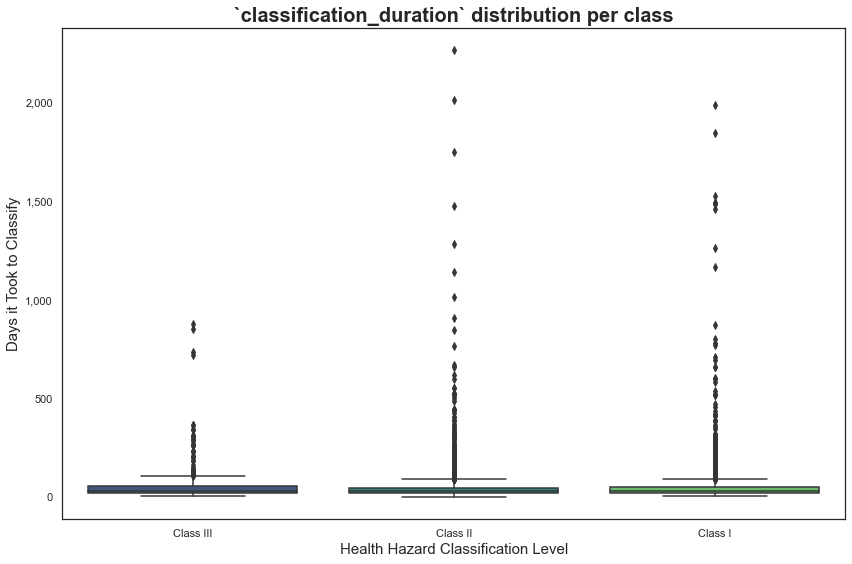

In [113]:
_ = sns.set(
    context='notebook',
    style='white',
    palette='pastel'
)

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

_ = sns.boxplot(x='classification',
                y='classification_duration',
                data=data,
                palette='viridis'
                )

_ = ax.set_xlabel('Health Hazard Classification Level', fontdict={'size': 15})
_ = ax.set_ylabel('Days it Took to Classify', fontdict={'size': 15})
_ = ax.set_title('`classification_duration` distribution per class',
                 fontdict={'size': 20, 'weight': 'bold'})
_ = ax.set_yticks(range(0, 2500, 500))
_ = ax.set_yticklabels(['{:,}'.format(x) for x in range(0, 2500, 500)])

plt.tight_layout()
plt.show()


At first glance, what's immediately noticeable are outliers in the thousands of days for both `Class II` and `Class I` incidents, highlighting a strong right-skewness within their respective distributions, with `Class II` being the most heavily skewed between the two. On further inspection of inner quartile regions across these three groups, we see relatively similar distributions between `Class III` and `Class I` incidents. Given our initial hypothesis, we would have instead expected to see a significant difference of `Class I` in comparison to the other two groups for this measure.

When looking at `classification_duration` in totality, we are not seeing anything that would support our hypothesis that more severe incidents take longer to classify than less severe incidents. The most and least severe incident types take nearly the same amount of time to be classified on average.

------

# Validating Our Hypothesis Through A/B Testing

 Does the level of event classification (`classification`) affect the duration it takes for classification (`classification_duration`)? To answer that, we will perform A/B Testing using average classification duration as a testing metric. For simplicity, We will only compare recall instances of `class I` and `class III` for testing. 
 
> $H_{\theta}$: Time it took to classify `Class I` recall instances is similar to time it took to classify `Class III`. 
 
> $H_{A}$: It takes longer to classify more hazardous events(`Class I`) than other classes.

 Our test statistic(t-score) is calculated:
 
\begin{equation}  t = \frac{x_{1}-x_{2}}{\sqrt{((s_{1})^2/n_{1}) + ((s_{2})^2/n_{2})}} \end{equation} 

where $x_{1}$ refers to the average classification duration of `Class III`, and $x_{2}$ refers to the average classification duration of `Class I`. We will conduct the testing at a significance level($\alpha$) of 0.05 **under the assumption that our $H_{\theta}$ is true**.

In [114]:
# We've already calculated all needed statistics earlier

df = stat_duration_per_class.T

display(df)


classification,Class III,Class II,Class I
Average Duration,58.52,51.06,58.73
Variance,8396.05,10703.36,14979.66
Count,444.00,2721.00,2281.00


To calculate p-value, we will use `stats.norm.cdf` function imported from `scipy` library. According to the documentation, `stats.norm.cdf(X)` calculates the probability that X will take a value less than or equal to X. But since `stats.norm.cdf(X)` calculates probability density of the left-side of observed value in distribution, our p-value can be computed through $1 - $`stats.norm.cdf(t_score)`.

In [115]:
class3_avg_duration = df.iloc[0, 0]
class1_avg_duration = df.iloc[0, -1]

class3_denom = df.iloc[1, 0]/df.iloc[2, 0]
class1_denom = df.iloc[1, -1]/df.iloc[2, -1]

mean_diff = class3_avg_duration - class1_avg_duration
denom = np.sqrt(class3_denom + class1_denom)

t_score = mean_diff/denom
p_val = 1 - stats.norm.cdf(t_score)

print('Hypothesis testing conducted at significance level of 0.05',
      ' the two extreme classes in our data produced:', '\n\n')
print(f't-score: {t_score}\np-value: {p_val}')


Hypothesis testing conducted at significance level of 0.05  the two extreme classes in our data produced: 


t-score: -0.041604826468780165
p-value: 0.5165931371952768


> Computed p-value is significantly larger than our significance level of $0.05$. According to the test result, our dataset does not have sufficient evidence to reject $H_{\theta}$ and thus, we fail to reject null hypothesis. Our dataset shows that it takes roughly same amount of time to classify all recall instances regardless of their classification type.

# Ethics & Privacy

The data has been provided by the FDA and is available to the public. Since the data is collected on the process of goods moving from supplier to store, no data on any one individual is collected. All firms from which the product was recalled either voluntarily filed the report themselves or are aware of the publicization of the recall. The outcome of whether or not the hazard level of a recall and the length of time it takes to classify it is related should not cause any ethical concerns. The answer would reveal if the most dangerous food products are recalled quicker than other minor level threats, such as Class II or Class III. This is a representation of how the FDA organizes its recalls, and it would give information on whether or not the system of the FDA could potentially improve in speeding up Class I product recalls. While unlikely to yield any actional information for bad actors looking to take advantage of any holes in this system and identifying best points of attack, we have made the advanced decision to keep our analysis private; our notebooks will only be shared amongst ourselves and the individual(s) who grades our project. Provided we do happen to directly find such critical information, we are obligated to securely pass on our findings to the appropriate government reporting agency.

However, even if our analysis is to be private, a concern we have to recognize and potential biases that may affect the project's results. We will perform caution when doing our analysis by not actively searching for favorable results that support our hypothesis. A consequence of this is that the report may show false information that will misrepresent the performance of the FDA. Nevertheless, the potential biases of this project shouldn't come up in this project, as there would be mostly exploratory data analysis.

# Conclusion & Discussion

### Conclusion

Through EDA, we found that the majority of recall events from the early 2010s to late 2010s got classified as `Class I` or `Class II`, and only a few were classified as `Class III`. This is one of the main causes of the imbalance in the number of observations with different classification levels in our dataset. We used a pie chart to visualize the imbalance, which showed that half of the entities are `Class II` instances. Subsequent visualization on the distribution of `classification_duration` confirmed that the majority of recall events took less than a year to get classified. We then discovered there is no statistically proven relationship between the `distribution scope` of the recall instance and the `classification duration` of that recall through a t-test. In the end, we compared the average classification duration between different health hazard classifications with horizontal bar charts.

Lastly, we conducted A/B testing to validate our belief that `Class I` recall cases take longer to get classified than `Class III` recall cases. Using the difference in average classification duration as a test metric, we computed the cumulative density of the observed difference on normalized distribution or p-value. As a result, the test produced a p-value far larger than our significance level($0.05$), supporting our $H_{\theta}$ that it takes roughly the same amount of time in classifying all recall events regardless of their health hazard level. Hence, we conducted our result that there does not exist statistically significant proof that establishes a relationship between `classification_duration` and `classification` in our dataset
 
### Limitations

 Our dataset involved several quality issues at the time we retrieved our dataset from the vendor. While the majority of the attributes were clearly explained by provided documentation, some attributes were missing descriptions that explain what the values under the attributes represented<font color=blue>$^{1}$</font>. Taking that into account, the majority of values were left out without any context explaining why they were missing, so we had to exclude several observations from our dataset before we performed any kind of analysis on it. This ambiguity in column description also confined our research scope; with such limited information about the data, we had to narrow down the scope in our analysis. 
 
Some limitations arose from the quality of data values themselves as well. Values under `distribution_pattern` in our raw data lacked consistency and uniformity among them, which made it difficult for us to extract useful information from them. Several columns also had incorrect data types assigned to them, disrupting the interpretation of data. For example, the date attributes we used to measure `classification duration` were not exactly "date" values, as they were not in the right format for us to compute `classification duration` from them. To resolve this, we performed data normalization on those problematic columns.
 
It is also worth mentioning that we lost a significant amount of data in the normalization process. We initially had ~21,000 observations of recall events. However, after identifying many records that belonged to the same overall recall event and dropping those duplicates, we were left with ~6,000 records. We were still able to perform effective analysis to validate our hypothesis and extract as many valuable insights as possible, but losing about 70% of data in the cleaning process is critical in the effective analysis as asserted by many data specialists: *more data is always better*.
 
 


 ### References
 
 1) [Attribute description](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=fda_food&t=food_enforcement&page=table&project=silken-avatar-335619&ws=!1m15!1m4!4m3!1sbigquery-public-data!2ssdoh_cdc_wonder_natality!3scounty_natality!1m4!4m3!1sbigquery-public-data!2sfda_food!3sfood_enforcement!1m4!4m3!1sbigquery-public-data!2sfda_food!3sfood_events) -- Google bigquery public-dataset cloud

# Team Contributions

- Jayden Lee
    * Data Sourcing, Data Cleaning, Conclusion
- Seth Menn
    * Data Cleaning, EDA, Ethics and Privacy
- Mingwen Jiang
    * Data Cleaning, EDA, Ethics and Pricacy
- William Nathan
    * Data Cleaning, EDA
- Antonio Murillo
    * Data Cleaning, EDA